In [1]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from transformers import TextStreamer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/workspace/pyenvs/wsi_vqa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
model, tokenizer = FastVisionModel.from_pretrained(
    "/workspace/whole_slide_image_LLM/data/vqa_dataset/save_path/checkpoint-2940",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.1.7: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 3060. Max memory: 11.755 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.4.0+cu118. CUDA: 8.6. CUDA Toolkit: 11.8. Triton: 3.0.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27.post2+cu118. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


In [3]:
FastVisionModel.for_inference(model) # Enable for inference!

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MllamaForConditionalGeneration(
      (vision_model): MllamaVisionModel(
        (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), padding=valid, bias=False)
        (gated_positional_embedding): MllamaPrecomputedPositionEmbedding(
          (tile_embedding): Embedding(9, 8197120)
        )
        (pre_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
          (embedding): Embedding(9, 5120)
        )
        (post_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
          (embedding): Embedding(9, 5120)
        )
        (layernorm_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (layernorm_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (transformer): MllamaVisionEncoder(
          (layers): ModuleList(
            (0-12): 13 x MllamaVisionEncoderLayer(
              (self_attn): MllamaVisionSdpaAttention(
               

In [4]:
from mmseg.apis import init_model, inference_model

config = "/workspace/whole_slide_image_LLM/wsi_level_vqa-main/tissue_segmentation/config/pidnet_cfg.py"
checkpoint = "/workspace/whole_slide_image_LLM/wsi_level_vqa-main/tissue_segmentation/work_dir/best_mIoU_iter_6400.pth"
seg_model = init_model(config, checkpoint)

/workspace/pyenvs/wsi_vqa/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


Loads checkpoint by local backend from path: /workspace/whole_slide_image_LLM/wsi_level_vqa-main/tissue_segmentation/work_dir/best_mIoU_iter_6400.pth


/media/kwbyun/new_volume/whole_slide_image_LLM/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/media/kwbyun/new_volume/whole_slide_image_LLM/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/workspace/pyenvs/wsi_vqa/lib/python3.10/site-packages/mmengine/runner/checkpoint.py:347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data wh

In [5]:
import cv2
image = cv2.imread("/workspace/whole_slide_image_LLM/data/test_imgs/BC_01_0233.png")
res = inference_model(seg_model, image)

/workspace/pyenvs/wsi_vqa/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/media/kwbyun/new_volume/whole_slide_image_LLM/mmsegmentation/mmseg/models/utils/wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (128, 128) is `x+1` and out size (1024, 1024) is `nx+1`
  warnings.warn(


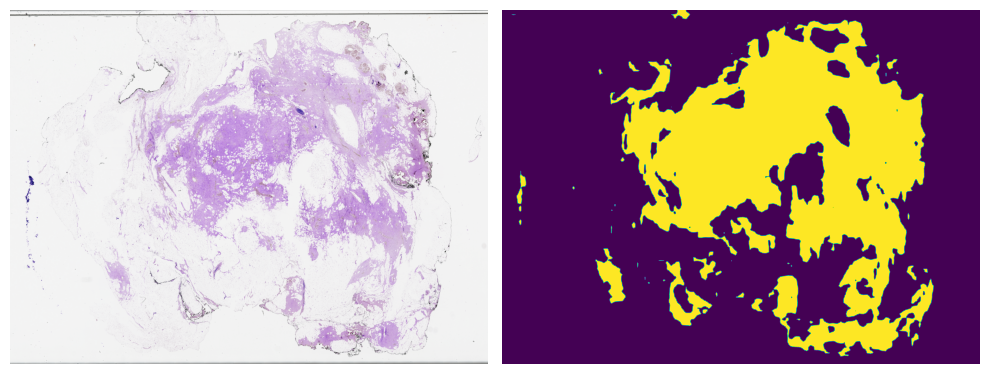

In [6]:
import matplotlib.pyplot as plt

mask = res.pred_sem_seg.data.detach().cpu().numpy()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image)
plt.axis("off")

plt.subplot(122)
plt.imshow(mask[0])
plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
from PIL import Image
import albumentations as A
from utils.image_preprocessing import crop_image

transform = A.Compose([
        A.LongestMaxSize(512),
        A.PadIfNeeded(
            min_height=512,
            min_width=512,
            border_mode=cv2.BORDER_CONSTANT,
            value=(255, 255, 255)  # RGB 흰색
        )])
    
instruction = "해당 wsi 영상을 진단해줘"
image = crop_image(image, mask[0])
image = transform(image = image)['image']
image = Image.fromarray(image)


messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

In [8]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)

inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

In [9]:
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 400,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

현재 Ductal(관상, 유관)으로 보입니다. 현재 whole slide image의 NG는 NG1입니다. 세포의 핵이 정상에 가깝게 보이며, 크기와 모양이 균일합니다. 분열(유사분열, mitosis)이 적고, 성장이 느린 암으로 간주됩니다. 예후가 상대적으로 좋습니다. 암의 위치는 왼쪽에 조직에 있는 것으로 보입니다.암의 개수는 1개인 것으로 보이며,가장 큰 암의 정경은 nanmm 인것으로 보입니다. 조직 내에서 DCIS 또는 LCIS가 존재하지만, EIC가 없는 상태입니다. 현재는 암이 림프절로 전이 되지 않은 걸로 보입니다.<|eot_id|>
